In [1]:
import pandas as pd
import numpy as np
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import os

## Model

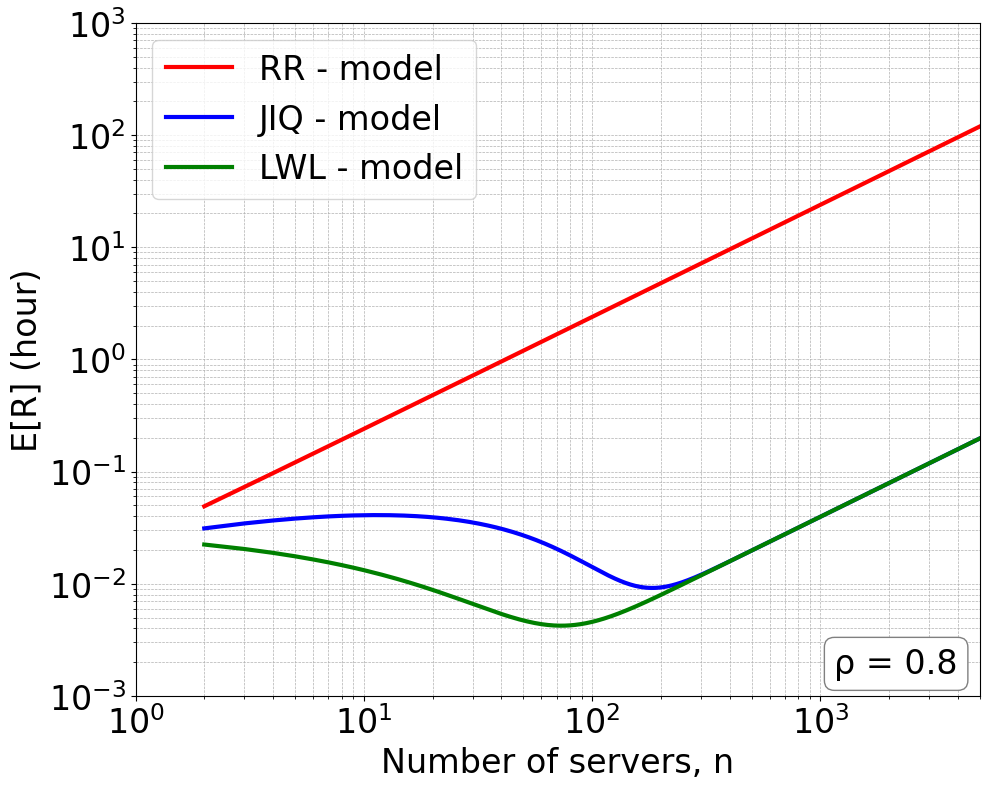

In [10]:
# Path to the output CSV file
path = '/home/mert/PhD/Alibaba_Data_Job_Level.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(path)

df = df[df.CPU>0].reset_index(drop=True)
df.CPU = df.CPU/100
d = int(input("Which day? [between 2 and 8] "))
df_daily = df[(df.Arrival_Time>84600*(d-1)) & (df.Arrival_Time<86400*d)].reset_index(drop=True)
df_daily['Job_ID'] = df_daily['Job_ID'].str.replace('j_', '').astype(int)

df_daily.to_csv('Alibaba_daily.csv', index=False)

# Load data from .mat file
df = pd.read_csv('Alibaba_daily.csv')
AJv = df['Arrival_Time'].values
CJv = df['CPU'].values

AJallv = AJv
CJallv = CJv
njob = len(AJv)
xv = np.sort(CJallv)
cutquant = 1
th = xv[int(np.ceil(cutquant * len(xv))) - 1]
jv = CJallv <= th
AJrv = AJallv[jv]
CJrv = CJallv[jv]
njobr = len(jv)

# Arrival process moments
Timehorizon = AJrv[-1] - AJrv[0]
IATv = np.diff(AJrv)
lambda_ = 1 / np.mean(IATv)
CA = np.std(IATv) / np.mean(IATv)
EC = np.mean(CJrv)
CX = np.std(CJrv) / EC

# Mean response time analysis
rho0 = 0.8
mutot = np.sum(CJrv) / Timehorizon / rho0

Nmin, Nmax = 2, 5000
Nv = np.arange(Nmin, Nmax + 1)
numN = len(Nv)

ERsinglestageRRv = []
ERsinglestageLWLv = []
ERsinglestageJIQv = []

for N in Nv:
    mu = mutot / N
    lambda1 = lambda_ / N
    CA1 = CA / np.sqrt(N)
    EX1 = EC / mu
    CX1 = CX
    rho1 = lambda1 * EX1
    scalef1 = (1 + CX1**2) * (CA1**2 + (rho1 * CX1)**2) / (1 + (rho1 * CX1)**2) / 2
    ERsinglestageRR = EX1 + EX1 * (rho1 / (1 - rho1)) * scalef1
    ERsinglestageRRv.append(ERsinglestageRR)

    EX = EC / mu
    A = lambda_ * EX
    B = 1
    for h in range(1, N + 1):
        B = A * B / (h + A * B)
    C = B / (1 - rho0 + rho0 * B)
    scalef = (1 + CX**2) * (CA**2 + (rho0 * CX)**2) / (1 + (rho0 * CX)**2) / 2
    ERsinglestageLWL = EX + EX * (C / (N * (1 - rho0))) * scalef
    ERsinglestageLWLv.append(ERsinglestageLWL)

    ERsinglestageJIQ = (1 - B) * ERsinglestageLWL + B * ERsinglestageRR
    ERsinglestageJIQv.append(ERsinglestageJIQ)

# Plot results
sechour = 3600
y1v = np.array(ERsinglestageRRv) / sechour
y2v = np.array(ERsinglestageJIQv) / sechour
y3v = np.array(ERsinglestageLWLv) / sechour

plt.figure(figsize=(10, 8))
plt.loglog(Nv, y1v, 'r-', linewidth=3.0, label="RR - model")
plt.loglog(Nv, y2v, 'b-', linewidth=3.0, label="JIQ - model")
plt.loglog(Nv, y3v, 'g-', linewidth=3.0, label="LWL - model")

plt.xlabel('Number of servers, n', fontsize=24)
plt.ylabel('E[R] (hour)', fontsize=24)
plt.legend(loc="upper left", fontsize=24)

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xlim(1, max(Nv))
plt.ylim(10**np.floor(np.log10(min(y3v))), 10**np.ceil(np.log10(max(y1v))))

plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)

plt.text(
    0.80 * max(Nv), 0.15 * min(y2v),  # Adjust x and y coordinates
    f"ρ = {rho0}",
    fontsize=24,
    ha='right',  # Horizontal alignment
    va='bottom',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')  # Box style

)
plt.tight_layout()
plt.show()

## Simulations

In [11]:
def RR_FCFS_calc_ER(Nse):
    Timehorizon = Av[-1] - Av[0]
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu
    Jv = jobIDppv

    tnow = 0.0
    Uv = np.zeros(Nse)                 # workload per server
    joblistv = np.unique(Jv)
    tstartjobv = np.full(len(joblistv), np.inf)
    tendjobv = np.zeros(len(joblistv))
    job_index = {jid: i for i, jid in enumerate(joblistv)}

    for ii in range(len(Av)):
        A = Av[ii]
        X = Xv[ii]

        # drain to arrival
        elapsed = A - tnow
        tnow = A
        Uv = np.maximum(0.0, Uv - elapsed)

        # Round-Robin dispatch (0,1,2,...,Nse-1,0,1,...)
        jsel = ii % Nse

        # enqueue
        Uv[jsel] += X

        # update job window
        jidx = job_index[Jv[ii]]
        if A < tstartjobv[jidx]:
            tstartjobv[jidx] = A
        finish = A + Uv[jsel]
        if finish > tendjobv[jidx]:
            tendjobv[jidx] = finish

    ERjob = np.mean(tendjobv - tstartjobv)
    return ERjob


In [12]:
def JIQ_FCFS_calc_ER(Nse):
    Timehorizon = Av[-1] - Av[0]
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu
    Jv = jobIDppv

    tnow = 0.0
    Uv = np.zeros(Nse)                  # workload per server
    joblistv = np.unique(Jv)
    njob = len(joblistv)
    tstartjobv = np.full(njob, np.inf)
    tendjobv = np.zeros(njob)

    # map job id -> compact index
    job_index = {jid: i for i, jid in enumerate(joblistv)}

    for ii in range(len(Av)):
        A = Av[ii]
        X = Xv[ii]

        # drain servers until current arrival
        elapsed = A - tnow
        tnow = A
        Uv = np.maximum(0.0, Uv - elapsed)

        # JIQ dispatch
        if np.min(Uv) > 0.0:
            jsel = np.random.randint(Nse)           # all busy: random server
        else:
            idle = np.where(Uv == 0.0)[0]
            jsel = idle[np.random.randint(len(idle))]

        # enqueue task
        Uv[jsel] += X

        # update job start/end
        jidx = job_index[Jv[ii]]
        if A < tstartjobv[jidx]:
            tstartjobv[jidx] = A
        finish = A + Uv[jsel]
        if finish > tendjobv[jidx]:
            tendjobv[jidx] = finish

    ERjob = np.mean(tendjobv - tstartjobv)
    return ERjob

In [13]:
def LWL_FCFS_calc_ER(Nse):
    Timehorizon = Av[-1] - Av[0]
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu
    Jv = jobIDppv

    tnow = 0.0
    Uv = np.zeros(Nse)                 # workload per server
    joblistv = np.unique(Jv)
    tstartjobv = np.full(len(joblistv), np.inf)
    tendjobv = np.zeros(len(joblistv))
    job_index = {jid: i for i, jid in enumerate(joblistv)}

    for ii in range(len(Av)):
        A = Av[ii]
        X = Xv[ii]

        # drain to arrival
        elapsed = A - tnow
        tnow = A
        Uv = np.maximum(0.0, Uv - elapsed)

        # LWL dispatch: pick server(s) with minimum work left, tie-break uniformly
        Umin = np.min(Uv)
        cand = np.where(Uv == Umin)[0]
        jsel = cand[np.random.randint(len(cand))]

        # enqueue
        Uv[jsel] += X

        # update job window
        jidx = job_index[Jv[ii]]
        if A < tstartjobv[jidx]:
            tstartjobv[jidx] = A
        finish = A + Uv[jsel]
        if finish > tendjobv[jidx]:
            tendjobv[jidx] = finish

    ERjob = np.mean(tendjobv - tstartjobv)
    return ERjob


In [ ]:
rho = 0.8  # target utilization

df = pd.read_csv('Alibaba_daily.csv')

# Get the start times and other data
Av = df['Arrival_Time'].values
Cv = df['CPU'].values
CJv = df['CPU'].values

jobIDppv = df['Job_ID'].values



# The Nse values you want to test
Nses = [2, 3, 4, 6, 8, 10, 20, 30, 40, 50, 100, 120, 150, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]

# --- Parallel runner (does NOT touch your functions) ---
def _init_globals(_Av, _Cv, _CJv, _jobIDppv):
    # Set globals once per worker so your functions can read them
    global Av, Cv, CJv, jobIDppv, rho
    Av, Cv, CJv, jobIDppv,rho = _Av, _Cv, _CJv, _jobIDppv, rho

def _run_all_policies(nse):
    # Optional: make JIQ tie-breaking reproducible per Nse
    rr = RR_FCFS_calc_ER(nse)
    jiq = JIQ_FCFS_calc_ER(nse)
    lwl = LWL_FCFS_calc_ER(nse)
    return (nse, rr, jiq, lwl)

if __name__ == "__main__":
    max_workers = os.cpu_count() or 1
    with ProcessPoolExecutor(
        max_workers=max_workers,
        initializer=_init_globals,
        initargs=(Av, Cv, CJv, jobIDppv),
    ) as ex:
        results = list(ex.map(_run_all_policies, Nses, chunksize=1))

    # Build the requested DataFrame
df_results = pd.DataFrame(results, columns=["Nse", "RR_FCFS", "JIQ_FCFS", "LWL_FCFS"]) \
                .sort_values("Nse") \
                .reset_index(drop=True)
df_results

,Nse,RR_FCFS,JIQ_FCFS,LWL_FCFS
0,2,1564.258247,1563.394270,1500.566633
1,3,1624.026062,1575.816293,1495.297274
2,4,1722.855685,1589.417126,1488.596180
3,6,1863.827685,1672.468519,1474.428163
4,8,2109.578614,1630.771025,1457.248963
5,10,2142.201956,1662.403376,1440.047904
6,20,2891.662613,1670.709836,1351.681666
7,30,3739.849588,1658.743262,1273.717211
8,40,3881.836869,1623.322090,1228.882233
9,50,4448.196474,1576.208727,1186.007311


In [15]:
Nses = df_results['Nse'].values
RR_FCFS_ERjob = df_results['RR_FCFS'].values
JIQ_FCFS_ERjob = df_results['JIQ_FCFS'].values
LWL_FCFS_ERjob = df_results['LWL_FCFS'].values
RR_FCFS_ERjob = RR_FCFS_ERjob / 3600
JIQ_FCFS_ERjob = JIQ_FCFS_ERjob / 3600
LWL_FCFS_ERjob = LWL_FCFS_ERjob / 3600

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


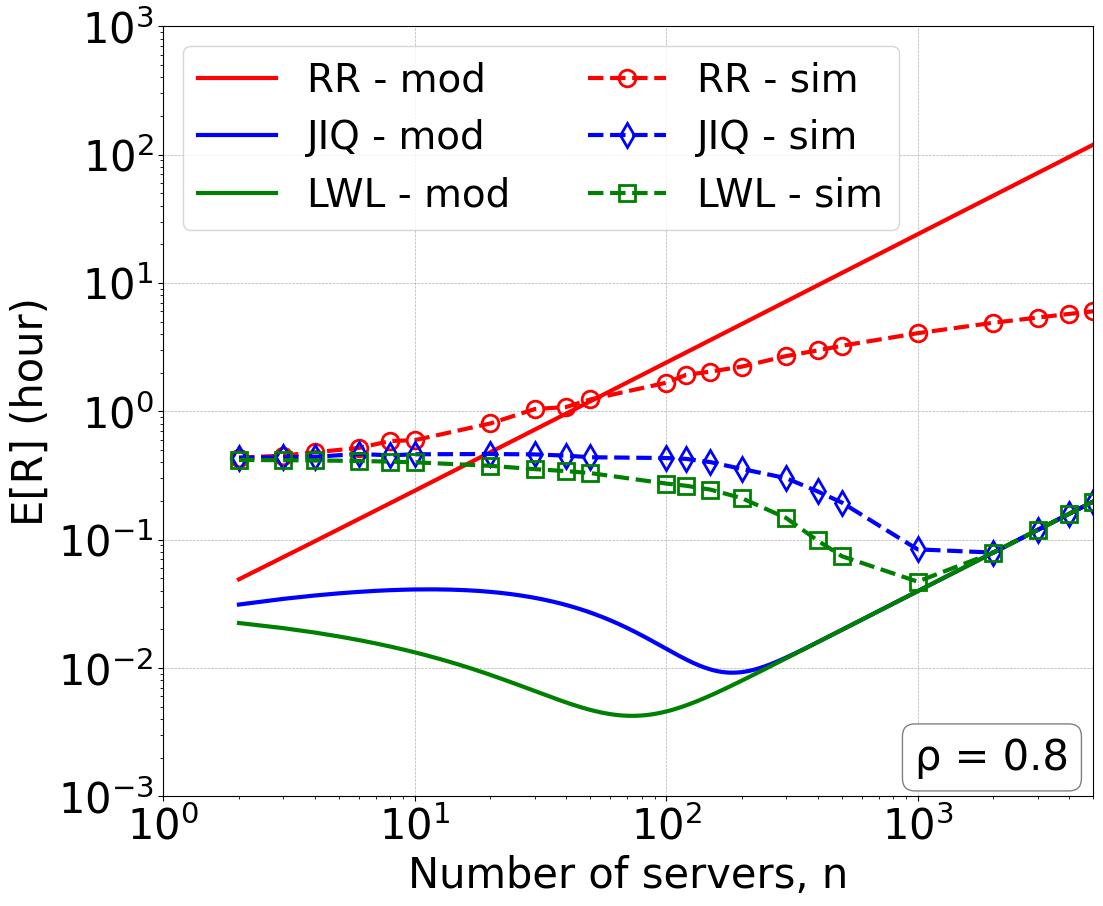

In [16]:
plt.figure(figsize=(12, 10))
plt.plot(Nv, y1v, 'r-', linewidth=3.0, label="RR - mod")
plt.plot(Nv, y2v, 'b-', linewidth=3.0, label="JIQ - mod")
plt.plot(Nv, y3v, 'g-', linewidth=3.0, label="LWL - mod")

plt.plot(Nses, RR_FCFS_ERjob, 'r--o', linewidth=3, markersize=12, 
         markerfacecolor='none', markeredgewidth=2, label='RR - sim')  # Red dashed line with circles
plt.plot(Nses, JIQ_FCFS_ERjob, 'b--d', linewidth=3, markersize=12, 
         markerfacecolor='none', markeredgewidth=2, label='JIQ - sim')  # Blue dashed line with triangles
plt.plot(Nses, LWL_FCFS_ERjob, 'g--s', linewidth=3, markersize=12, 
         markerfacecolor='none', markeredgewidth=2, label='LWL - sim')  # Green dashed line with squares

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Number of servers, n', fontsize=30)
plt.ylabel('E[R] (hour)', fontsize=30)
plt.legend(loc="upper left", fontsize=28, ncol=2)
plt.xlim(1, max(Nv))
plt.ylim(10**np.floor(np.log10(min(y3v))), 10**np.ceil(np.log10(max(y1v))))

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.text(
    0.80 * max(Nv), 0.15 * min(y2v),  # Adjust x and y coordinates
    f"ρ = {rho0}",
    fontsize=30,
    ha='right',  # Horizontal alignment
    va='bottom',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')  # Box style

)

plt.grid(True, which="major", linestyle='--', linewidth=0.5)
plt.savefig('Outputs/ModSim_Normal_A.eps', format='eps', bbox_inches='tight')

plt.show()
